In [1]:
import pandas as pd
from sklearn.linear_model import Lasso, LassoCV, LogisticRegressionCV, LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.model_selection import KFold
from sklearn.dummy import DummyRegressor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

#custom model implementations and useful functions are stored here:
from dairyml import PerfectClassifierMeanRegressor, plot_r2


## Import the Data
Load the data from the csv file, and set FoodCode to be the data index

In [2]:
data = pd.read_csv('../data/training_for_GS_122118.csv')
data = data.set_index('FoodCode')

Get the indices of all columns except description and lactose content - these columns are the numerical features that will be used as model input



In [3]:
numerical_features = data.columns[1:-1]

## Prepare data for modelling
### Standardize the input features
- Use only the numerical features as model input `X`  
- Use sklearn's `StandardScaler` on these features: this standardizes features by removing the mean and scaling to unit variance 
- Convert the output of `StandardScaler` back to a dataframe for convenience

In [4]:
ss = StandardScaler()
X = pd.DataFrame(ss.fit_transform(data[numerical_features]),columns=data[numerical_features].columns)
# X.head()

### Use lactose as prediction target `Y`

In [5]:
Y = data['lac.per.100g']
# Y.head()

## Modelling

We will use the below splitter for cross-validation- 10 folds, with shuffling

In [6]:
splitter= KFold(n_splits=10,shuffle=True,random_state=7)

### Baseline Models


#### Mean

In [7]:
dummy_mean = DummyRegressor(strategy='mean')
dummy_mean_score = np.round(np.mean(cross_val_score(dummy_mean,X,Y,cv=splitter,scoring='r2')),2)

print('Dummy model (Mean) testing R^2: {}'.format(dummy_mean_score))

Dummy model (Mean) testing R^2: -0.02


#### Median

In [8]:
dummy_mean = DummyRegressor(strategy='median')
dummy_mean_score = np.round(np.mean(cross_val_score(dummy_mean,X,Y,cv=splitter,scoring='r2')),2)

print('Dummy model (Median) testing R^2: {}'.format(dummy_mean_score))

Dummy model (Median) testing R^2: -0.29


#### Perfect classifier plus mean regressor
- This classifier predicts 0 where the true value is 0, or the mean of the training lactose values where the true value is nonzero

- See dairyml.py for implementation

(This class is not compliant with sklearn conventions, this was the easiest implementation I could think of to include perfect classification)

In [9]:
pcmr = PerfectClassifierMeanRegressor()
pcmr.fit(X,Y)
dummy_pcmr_score = np.round(np.mean(pcmr.cross_val()),2)

print('Dummy model (Perfect Classification, Mean Regression) testing R^2: {}'.format(dummy_pcmr_score))

Dummy model (Perfect Classification, Mean Regression) testing R^2: 0.12


### Lasso

- Conduct a grid search on the regularization parameter alpha on a log scale between 1e-3 and 1 (np.logspace takes exponents of 10 as arguments)
- For each value of alpha in this range, we perform 10-fold cross validation (CV) on the training data
- Choose the best model based on R^2 score in CV using the `refit` argument of `GridSearchCV`

In [10]:
param_grid = {'alpha': np.logspace(-3, 0, 50)}

refit = 'r2'

search = GridSearchCV(estimator=Lasso(),param_grid=param_grid,scoring=('neg_mean_squared_error','r2','explained_variance'),refit=refit,cv=10)
search.fit(X,Y)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([0.001  , 0.00115, 0.00133, 0.00153, 0.00176, 0.00202, 0.00233,
       0.00268, 0.00309, 0.00356, 0.00409, 0.00471, 0.00543, 0.00625,
       0.0072 , 0.00829, 0.00954, 0.01099, 0.01265, 0.01456, 0.01677,
       0.01931, 0.02223, 0.0256 , 0.02947, 0.03393, 0.03907, 0.04498,...18, 0.32375,
       0.37276, 0.42919, 0.49417, 0.56899, 0.65513, 0.75431, 0.86851,
       1.     ])},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score='warn',
       scoring=('neg_mean_squared_error', 'r2', 'explained_variance'),
       verbose=0)

### Best value of alpha for Lasso
Print the best value of the regularization parameter, as chosen by 10-fold CV R^2 score above

In [11]:
search.best_estimator_.alpha

0.0517947467923121

### Model test performance
Highest R^2 score for the Lasso model from 10-fold CV (this is the performance we can expect on the test set)

In [12]:
search.cv_results_['mean_test_r2'][np.argmax(search.cv_results_['mean_test_'+refit])]

0.36358761906352877

### Model performance after refitting to the full training set

To take advantage of all the available data, we refit the model to the full training set. (This happens above in `GridSearchCV` automatically). Below we report the "training" R^2 value:

In [13]:
search.score(X,Y)

0.6759509859803272

In [14]:
plot_r2(search,'Lasso')

NameError: name 'X' is not defined

# Bounded Lasso
This attempts to fix an obvious issue with the above predictor, that the model predicts negative lactose content for some foods. BoundedLasso wraps sklearn's Lasso model, and "clips" the model output so that negative output values become 0. 

In [18]:
class BoundedLasso(BaseEstimator,RegressorMixin):
    def __init__(self, alpha=None):
        self.alpha = alpha
        
    def fit(self,X,y):
        self.lasso = Lasso(self.alpha)
        self.lasso.fit(X,y)
    
    def get_coef(self):
        return self.lasso.coef_
    
    def predict(self, x):
        pred_orig = self.lasso.predict(x)
        return np.clip(pred_orig,0,np.max(pred_orig))

In [97]:
param_grid = {'alpha': np.logspace(-3, 0, 100)}

refit = 'r2'

search = GridSearchCV(estimator=BoundedLasso(),param_grid=param_grid,scoring=('neg_mean_squared_error','r2'),refit=refit,cv=10)
search.fit(X,Y)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=BoundedLasso(alpha=None), fit_params=None, iid='warn',
       n_jobs=None,
       param_grid={'alpha': array([0.001  , 0.00107, ..., 0.9326 , 1.     ])},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score='warn',
       scoring=('neg_mean_squared_error', 'r2'), verbose=0)

### Best value of alpha for Bounded Lasso
Print the best value of the regularization parameter, as chosen by 10-fold CV R^2 score above

In [98]:
search.best_estimator_.alpha

0.04328761281083059

### Model test performance
Highest R^2 score for the Lasso model from 10-fold CV (this is the performance we can expect on the test set)

Performance has improved slightly over the regular Lasso model, from .36 to .38

In [99]:
search.cv_results_['mean_test_r2'][np.argmax(search.cv_results_['mean_test_'+refit])]

0.38489032671670603

### Model performance after refitting to the full training set

To take advantage of all the available data, we refit the model to the full training set. (This happens above in `GridSearchCV` automatically). Below we report the "training" R^2 value:

In [100]:
search.score(X,Y)

0.7015004716693365

### Plot training performance: predicted vs actual values

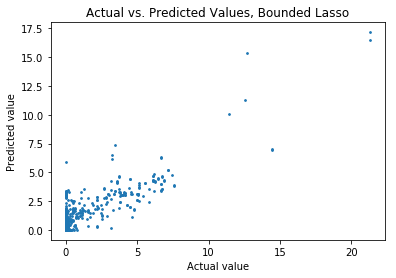

In [101]:
plot_r2(search,'Bounded Lasso')

## Feature importances
Here we plot the non-zero coefficients of the Bounded Lasso model. The magnitude of the coefficient for each feature indicates how much each feature contributes to the overall lactose estimate. We can see that choline, sugar, and potassium contribute positively to the lactose estimate, while fiber, cholesterol, and protein contribute negatively. 

In [102]:
def plot_coefficients(model):
    try:
        nonzero_coef_index = model.coef_ != 0
        coefficients = pd.DataFrame()
        coefficients['Feature'] = X.columns
        coefficients['coef'] = model.coef_
    except AttributeError:
        nonzero_coef_index = model.get_coef() != 0
        coefficients = pd.DataFrame()
        coefficients['Feature'] = X.columns
        coefficients['coef'] = model.get_coef()
    axs = coefficients[coefficients['coef']!=0].sort_values('coef').plot.barh(x='Feature',y='coef')
    axs.set_title('Feature Coefficients')
    axs.set_xlabel('Coefficient')

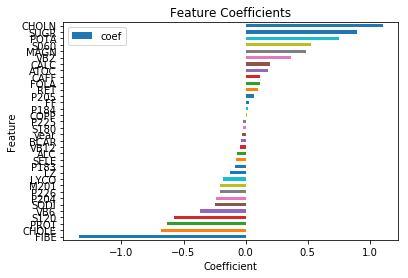

In [105]:
plot_coefficients(search.best_estimator_)

## Bounded Lasso plus Classifier
- Add a binary classifier to the model to predict whether a food is zero or non-zero lactose. 
- In the case that the classifier predicts 0 lactose, the overall model output is 0. 
- In the case that the classifier predicts non-zero, the output from the bounded lasso model is used

### Evaluate the classifier by itself

In [14]:
Y_binary.value_counts()

NameError: name 'Y_binary' is not defined

In [15]:
Y_binary = Y != 0

param_grid_LR = {'C': np.logspace(-4, 4, 30)}
param_grid_SVC = {'C': np.logspace(-4, 4, 30)}

search_LR = GridSearchCV(estimator=LogisticRegression(solver='lbfgs',max_iter=2000),param_grid=param_grid_LR,scoring=('accuracy','recall'),refit='accuracy',cv=10)
search_LR.fit(X,Y_binary)

# search_SVC = GridSearchCV(estimator=SVC(kernel='rbf'),param_grid=param_grid_SVC,scoring=('accuracy','recall'),refit='accuracy',cv=10)
# search_SVC.fit(X,Y_binary)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



#### Classifier accuracy
The classifier achieves 89% accuracy in predicting 0 vs non-zero lactose.

In [109]:
search_LR.best_score_

0.8941798941798942

### Evaluate the Bounded Lasso + Classifier Model

In [19]:
class BoundedLassoPlusLogReg(BaseEstimator,RegressorMixin):
    def __init__(self, alpha=None, C=None):
        self.alpha = alpha
        self.C = C

    def fit(self,X,y):
        self.bounded_lasso = BoundedLasso(alpha=self.alpha)
        self.logreg = LogisticRegression(penalty='l2',C=self.C,solver='lbfgs')
        self.bounded_lasso.fit(X,y)
        y_binary = y != 0
        self.logreg.fit(X,y_binary)
        return self
        
    def predict(self, X):
        pred_lasso = self.bounded_lasso.predict(X)
        pred_logreg = self.logreg.predict(X)
        pred = np.multiply(pred_lasso,pred_logreg)
        return pred

In [20]:
param_grid = {'alpha': np.logspace(-3, -1, 10), 'C': np.logspace(-4, 4, 10)}
refit='r2'
search = GridSearchCV(estimator=BoundedLassoPlusLogReg(),param_grid=param_grid,scoring=('neg_mean_squared_error','r2'),refit=refit,cv=splitter)
search.fit(X,Y)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise-deprecating',
       estimator=BoundedLassoPlusLogReg(C=None, alpha=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([0.001  , 0.00167, 0.00278, 0.00464, 0.00774, 0.01292, 0.02154,
       0.03594, 0.05995, 0.1    ]), 'C': array([1.00000e-04, 7.74264e-04, 5.99484e-03, 4.64159e-02, 3.59381e-01,
       2.78256e+00, 2.15443e+01, 1.66810e+02, 1.29155e+03, 1.00000e+04])},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score='warn',
       scoring=('neg_mean_squared_error', 'r2'), verbose=0)

In [21]:
search.best_estimator_.get_params()

{'C': 1291.5496650148827, 'alpha': 0.03593813663804626}

### Model test performance
Highest R^2 score for the Lasso model from 10-fold CV (this is the performance we can expect on the test set)

Performance isn't significantly improved over the model without classifier.

In [22]:
search.best_score_

0.577671949896289